# Load, parse and split data

In [2]:
import pandas as pd
import numpy as np
from training.predictionAlgo import naiveNextEventPredictor, naiveTimeToNextEventPredictor
from preprocessing.dataParsing import parseData
from preprocessing.dataSplitting import dataSplitter
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from math import ceil

# Convert csv into dataframe
df_training_raw = pd.read_csv('.\data\BPI2012Training.csv')
df_test_raw = pd.read_csv('.\data\BPI2012Test.csv')

# Parsing data
(df_training, df_2012_last_event_per_case_train) = parseData(df_training_raw)
(df_test, df_2012_last_event_per_case_test) = parseData(df_test_raw)

# Clean and split the data into train, validation & test data
(df_training, df_validation, df_test) = dataSplitter(df_training, df_test)

ModuleNotFoundError: No module named 'keras'

# Prepare input of lstm for event prediction

In [28]:
def eventInputLstm(df, core_features: list, extra_features: list, scaler_encoder: list, window_size: int):
    '''
    args:
    df <class: 'pd.DataFrame'>: Dataframe of interest, filled with the features of arguments.
    core_features <class: 'list'>: Column names of the core features in format of [case id, current event, next event].
    extra_features <class: 'list'>: Extra features that the user wishes to train on, can be given in any sequences.
    scaler_encoder <class: 'list' of 'sklearn.preprocessing.MinMaxScaler' or klearn.preprocessing.OneHotEncoder>: 
    Trained scaler or encoder associated with the input features by their index that is used to normalise float or int features and encode categorical features.
    window_size <class: 'int'>: Window size of lstm input.
    
    returns:
    x_arr <'np.array'>: LSTM input in format [samples, timestep, features].
    y_arr <'np.array'>: LSTM input in format [samples, features].
    '''
    case_id_col = core_features[0]
    event_id_col = core_features[1]
    y_output_col = core_features[2]
    
    scaler_encoder_copy = scaler_encoder.copy()
    
    encoder_events = scaler_encoder_copy.pop(0)
    
    # Prevent modifying argument
    relevant_columns = core_features.copy()
    try:
        relevant_columns.extend(extra_features)
    except:
        print('Please input valid features.')
    
    df_relevant = df[relevant_columns].copy()

    # One-hot encode current and next event
    current_event = df_relevant[event_id_col].to_numpy().reshape(-1, 1)
    df_relevant[event_id_col] = encoder_events.transform(current_event).tolist()

    next_event = df_relevant[y_output_col].to_numpy().reshape(-1, 1)
    df_relevant[y_output_col] = encoder_events.transform(next_event).tolist()
    
    # Normalise extra features that are ints or floats
    for idx, scaler in enumerate(scaler_encoder_copy):
        if scaler != 0:
            to_be_normalised = df_relevant[extra_features[idx]].to_numpy().reshape(-1, 1)
            df_relevant[extra_features[idx]] = scaler.transform(to_be_normalised)

    # Prepare input and output in form of [samples, features]
    x = []
    y = []

    # Get groupby object df by case id
    df_groupby_case_id = df_relevant.groupby(case_id_col)

    # Unique case ids
    unique_case_ids = df_relevant[case_id_col].unique().tolist()

    # Find input and output vector in form of [samples, features]
    for unique_id in unique_case_ids:
        columns_relevant = [event_id_col, y_output_col].copy()
        columns_relevant.extend(extra_features)
        xy_unique_id = df_groupby_case_id.get_group(unique_id)[columns_relevant].values.tolist()
        sequence_x_unique_id = []

        # event[0] = current event, event[1] = next event, event[2] = first selected feature, event[3] = second selected feature,...
        for idx, event in enumerate(xy_unique_id):
            if len(sequence_x_unique_id) == window_size:
                del sequence_x_unique_id[0]

            event_memory = event[0].copy()
            event_memory.extend(event[2:])
            sequence_x_unique_id.append(event_memory.copy())
            x.append(sequence_x_unique_id.copy())
            y.append(event[1])
    
    # Alter input to [samples, timestep, features] for lstm, zero padding used to equalize timestep length
    x_arr = pad_sequences(x, dtype='float32')
    
    # Convert y to format [samples, features]
    y_arr = np.reshape(y, (-1, len(y[0])))

    return x_arr, y_arr

In [29]:
# Determine actual next event
(df_training, df_validation) = naiveNextEventPredictor(df_training, df_validation)
(df_training, df_test) = naiveNextEventPredictor(df_training, df_test)

unique_training_events = df_training['event concept:name'].unique().reshape(-1, 1)

# Define One-hot encoder for events
onehot_encoder_event = OneHotEncoder(sparse=False, handle_unknown='ignore')
onehot_encoder_event = onehot_encoder_event.fit(unique_training_events)

# see function comment for format
core_features = ['case concept:name', 'event concept:name', 'actual_next_event']

# Example with unix_reg_time as extra features
extra_features = ['event lifecycle:transition']

# now determining which feature of the extra features needs to be normalised becomes possible by inspecting the index of scalers list
encoder_scaler = [onehot_encoder_event] + [0]*len(extra_features)

# Instatiate scalers for features consisting out of the type float or int or encoder for categorical featurees
for idx, extra_feature in enumerate(extra_features):
    if len(df_training[extra_feature].unique()) < 20:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        arr_to_be_encoded = df_training[extra_feature].to_numpy().reshape(-1, 1)
        encoder = encoder.fit(arr_to_be_encoded)
        encoder_scaler[idx + 1] = encoder
    else:
        scaler = MinMaxScaler(feature_range=(0,1))
        arr_to_be_normalied = df_training[extra_feature].to_numpy().reshape(-1, 1)
        scaler = scaler.fit(arr_to_be_normalied)
        encoder_scaler[idx + 1] = scaler

# window size as the mean of case length
number_events_mean = df_training.groupby('case concept:name').count()['event concept:name'].mean()
number_events_mean = ceil(number_events_mean)

x_train, y_train = eventInputLstm(df_training, core_features, extra_features, encoder_scaler, number_events_mean)
x_val, y_val = eventInputLstm(df_validation, core_features, extra_features, encoder_scaler, number_events_mean)
x_test, y_test = eventInputLstm(df_training, core_features, extra_features, encoder_scaler, number_events_mean)

In [31]:
len(x_train[0][0])

25

# Prepare input of LSTM for time prediction

In [10]:
def timeInputLstm(df, core_features: list, extra_features: list, scaler_encoder: list, window_size: int):
    '''
    args:
    df <class: 'pd.DataFrame'>: Dataframe of interest, filled with the features of arguments.
    core_features <class: 'list'>: Column names of the core features in format of [case id, current event, time to next event].
    extra_features <class: 'list'>: Extra features that the user wishes to train on, can be given in any sequences.
    scaler_encoder <class: 'list' of 'sklearn.preprocessing.MinMaxScaler' or klearn.preprocessing.OneHotEncoder>: 
    Trained scaler or encoder associated with the input features by their index that is used to normalise float or int features and encode categorical features.
    window_size <class: 'int'>: Window size of lstm input.
    
    returns:
    x_arr <'np.array'>: LSTM input in format [samples, timestep, features].
    y_arr <'np.array'>: LSTM input in format [samples, features].
    '''
    # See function comment for format
    case_id_col = core_features[0]
    event_id_col = core_features[1]
    y_output_col = core_features[2]
    
    scaler_encoder_copy = scaler_encoder.copy()
    
    encoder_events = scaler_encoder_copy.pop(0)

    time_to_next_scaler = scaler_encoder_copy.pop(0)
    
    # Prevent modifying argument
    relevant_columns = core_features.copy()
    relevant_columns.extend(extra_features)
    
    try:
        df_relevant = df[relevant_columns].copy()
    except:
        print('Please input valid features.')

    # One-hot encode current event
    current_event = df_relevant[event_id_col].to_numpy().reshape(-1, 1)
    df_relevant[event_id_col] = encoder_events.transform(current_event).tolist()

    # Normalise time to next event.
    time_to_next_event = df_relevant[y_output_col].to_numpy().reshape(-1, 1)
    df_relevant[y_output_col] = time_to_next_scaler.transform(time_to_next_event)
    
    for idx, scaler_encoder in enumerate(scaler_encoder_copy):
            to_be_normalised_or_encoded = df_relevant[extra_features[idx]].to_numpy().reshape(-1, 1)
            df_relevant[extra_features[idx]] = scaler_encoder.transform(to_be_normalised_or_encoded)

    # Prepare input and output in form of [samples, features]
    x = []
    y = []

    # Get groupby object df by case id
    df_groupby_case_id = df_relevant.groupby(case_id_col)

    # Unique case ids
    unique_case_ids = df_relevant[case_id_col].unique().tolist()
    
    # Remove case id out of relevant columns
    del relevant_columns[0]

    # Find input and output vector in form of [samples, features]
    for unique_id in unique_case_ids:
        xy_unique_id = df_groupby_case_id.get_group(unique_id)[relevant_columns].values.tolist()
        sequence_x_unique_id = []

        # event[0] = current event, event[1] = actual time to next event, event[2] = first selected feature, event[3] = second selected feature,...
        for event in xy_unique_id:
            if len(sequence_x_unique_id) == number_events_mean:
                del sequence_x_unique_id[0]

            event_memory = event[0].copy()
            event_memory.extend(event[2:])
            sequence_x_unique_id.append(event_memory.copy())
            x.append(sequence_x_unique_id.copy())
            y.append(event[1])
    
    # Alter input to [samples, timestep, features] for lstm, zero padding used to equalize timestep length
    x_arr = pad_sequences(x, dtype='float32')
    
    # Convert y to format [samples, features]
    y_arr = np.reshape(y, (-1, 1))

    return x_arr, y_arr

In [17]:
(df_training, df_validation) = naiveTimeToNextEventPredictor(df_training, df_validation)
(df_training, df_test) = naiveTimeToNextEventPredictor(df_training, df_test)

unique_training_events = df_training['event concept:name'].unique().reshape(-1, 1)

# Define One-hot encoder for events
onehot_encoder_event = OneHotEncoder(sparse=False, handle_unknown='ignore')
onehot_encoder_event = onehot_encoder_event.fit(unique_training_events)

def eventDay(dataSet):
    dataSet["day"] = pd.to_datetime(dataSet["event time:timestamp"]).dt.day
def eventStartHour(dataSet):
    dataSet["hour"] = pd.to_datetime(dataSet["event time:timestamp"]).dt.hour
    
eventDay(df_training)
eventStartHour(df_training)

# Normalise time to next event.
# Hard coded column can be replaced as argument
time_to_next_scaler = MinMaxScaler(feature_range=(0,1))
time_to_next_event = df_training['actual_time_to_next_event'].to_numpy().reshape(-1, 1)
time_to_next_scaler = time_to_next_scaler.fit(time_to_next_event)

# see function comment for format
core_features = ['case concept:name', 'event concept:name', 'actual_time_to_next_event']

# Example with unix_reg_time as extra features
extra_features = ['event lifecycle:transition', 'day']

# now determining which feature of the extra features needs to be normalised becomes possible by inspecting the index of scalers list
encoder_scaler = [onehot_encoder_event, time_to_next_scaler] + [0]*len(extra_features)

# Instatiate scalers for features consisting out of the type float or int or encoder for categorical featurees
for idx, extra_feature in enumerate(extra_features):
    if len(df_training[extra_feature].unique()) < 20:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        arr_to_be_encoded = df_training[extra_feature].to_numpy().reshape(-1, 1)
        encoder = encoder.fit(arr_to_be_encoded)
        encoder_scaler[idx + 2] = encoder
    else:
        scaler = MinMaxScaler(feature_range=(0,1))
        arr_to_be_normalied = df_training[extra_feature].to_numpy().reshape(-1, 1)
        scaler = scaler.fit(arr_to_be_normalied)
        encoder_scaler[idx + 2] = scaler
        
# window size as the mean of case length
number_events_mean = df_training.groupby('case concept:name').count()['event concept:name'].mean()
number_events_mean = ceil(number_events_mean)

x_train, y_train = timeInputLstm(df_training, core_features, extra_features, encoder_scaler, number_events_mean)

In [19]:
len(x_train[10][0])

26

# LSTM for event prediction

In [22]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

import os
import tensorflow as tf
from tensorflow import keras

CLASS_SIZE = unique_training_events.shape[0]

def model_fn(labels_dim):
    """Create a Keras Sequential model with layers."""
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(256, input_shape=(number_events_mean, unique_training_events.shape[0])))
    model.add(keras.layers.Dropout(0.20))
    model.add(keras.layers.Dense(labels_dim, activation='softmax'))
    model.summary()
    compile_model(model)
    return model

def compile_model(model):
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def get_latest(checkpoint_dir, filetype='.h5', signature='cp', overwrite=False):
    """ 
        This is a workaround as tf.train.latest_checkpoint does not seem to
        work well on codalab. Give preference to that function when possible.

        If overwrite is True, the latest checkpoint is reset to 0 and all 
        others are deleted.
    """
    latest = None
    latest_number = -1
    for filename in os.listdir(checkpoint_dir):
        reference, extension = os.path.splitext(filename)
        if extension == filetype and reference.startswith('cp'):
            number = int(re.sub(r"\D", "", reference))
            if number > latest_number:
                latest = filename
                latest_number = number
            else:
                if overwrite:
                    os.remove(os.path.join(checkpoint_dir, filename))
    if latest is None:
        raise ValueError('No previous checkpoint found.')
    if overwrite:
        os.rename(os.path.join(checkpoint_dir, latest), os.path.join(checkpoint_dir, 'cp-0000.h5'))
        latest = 'cp-0000.h5'
        shutil.rmtree(os.path.join(checkpoint_dir, 'logs')) 
    return os.path.join(checkpoint_dir, latest)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [23]:
FILE_PATH="cp-{epoch:04d}.h5"
LSTM_MODEL = 'lstm.h5'

def run(num_epochs=20,  # Maximum number of epochs on which to train
        train_batch_size=128,  # Batch size for training steps
        job_dir='jobdir', # Local dir to write checkpoints and export model
        checkpoint_epochs='epoch',  #  Save checkpoint every epoch
        load_previous_model=False):
  
    """ This function trains the model for a number of epochs and returns the 
        training history. The model is periodically saved for later use.

        You can load a pre-trained model with 
            `model.load_weights(cp_path)`
        where `model` is a keras object (e.g. as returned by `model_fn`) and 
        `cp_path` is the path for the checkpoint you want to load.
        
        Setting load_previous_model to True will load the latest checkpoint in
        `job_dir` and continue training. That checkpoint is renamed cp-0000.h5,
        while all logs and other checkpoints are deleted. Use with care!
    
    """
    
    tf.keras.backend.clear_session()

    try:
        os.makedirs(job_dir)
    except:
        pass

    checkpoint_path = FILE_PATH
    checkpoint_path = os.path.join(job_dir, checkpoint_path)

    lstm_model = model_fn(CLASS_SIZE)
    if load_previous_model:
        # Load the previously saved weights
        latest = get_latest(job_dir, overwrite=True)
        lstm.load_weights(latest)
#         lstm_model.load_weights('jobdir\cp-0000.h5')

    # Model checkpoint callback
    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        verbose=2,
        save_freq=checkpoint_epochs,
        mode='max')

    # Tensorboard logs callback
    tblog = keras.callbacks.TensorBoard(
        log_dir=os.path.join(job_dir, 'logs'),
        histogram_freq=0,
        update_freq='epoch',
        write_graph=True,
        embeddings_freq=0)

#     #implemented earlystopping
#     callbacks = [checkpoint, tblog, keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6)]

    callbacks = [checkpoint, tblog]

    history = lstm_model.fit(
              x=x_train,
              y=y_train, 
              validation_data = (x_val, y_val),
              batch_size=train_batch_size,
              steps_per_epoch=None,
              epochs=num_epochs,
              callbacks=callbacks,
              verbose=2)
    
    lstm_model.save(os.path.join(job_dir, LSTM_MODEL))

    return history

In [24]:
history = run(load_previous_model=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               287744    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                6168      
Total params: 293,912
Trainable params: 293,912
Non-trainable params: 0
_________________________________________________________________
Train on 193273 samples, validate on 21104 samples
Epoch 1/20

Epoch 00001: saving model to jobdir\cp-0001.h5
193273/193273 - 15s - loss: 0.7034 - accuracy: 0.7358 - val_loss: 0.4373 - val_accuracy: 0.7965
Epoch 2/20

Epoch 00002: saving model to jobdir\cp-0002.h5
193273/193273 - 11s - loss: 0.4648 - accuracy: 0.7902 - val_loss: 0.4050 - val_accuracy: 0.7970
Epoch 3/20

Epoch 0

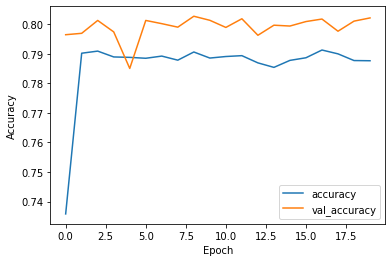

In [25]:
import matplotlib.pyplot as plt

# Plot history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

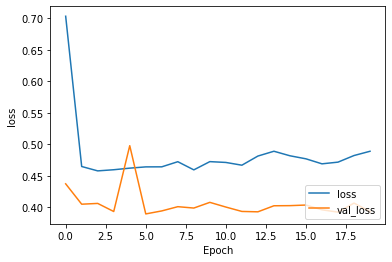

In [26]:
# Plot history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

In [ ]:
# Or visualise using Tensorboard
%tensorboard --logdir jobdir/logs

In [1]:
pip freeze > requirements

Note: you may need to restart the kernel to use updated packages.
